## 2024 Week 9 - Prep Air Capacity
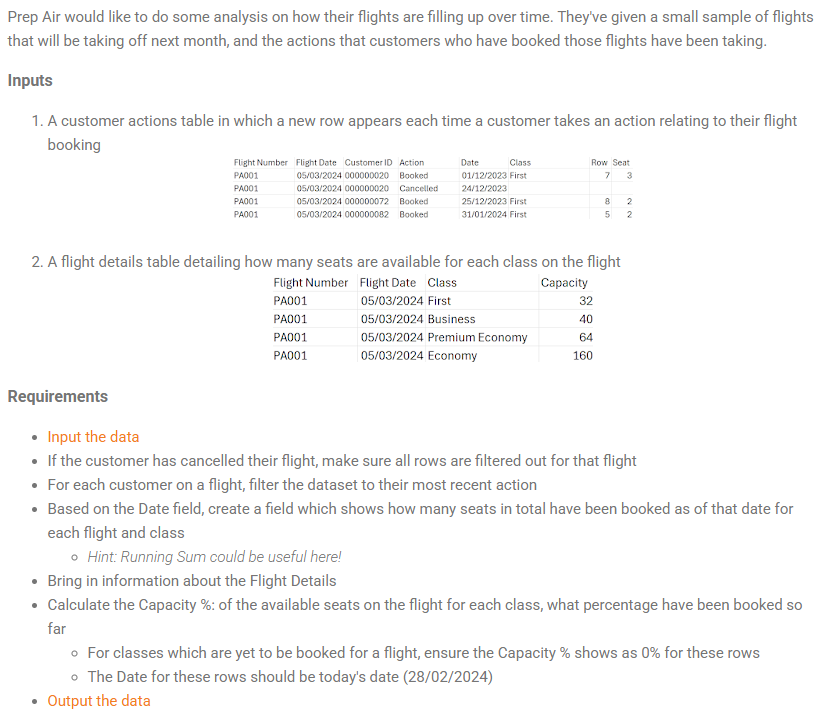

In [71]:
import pandas as pd

In [72]:
df = pd.read_excel('PD 2024 Week 9 Input.xlsx', sheet_name=None)
df.keys()

dict_keys(['Customer Actions', 'Flight Details'])

In [73]:
customers_actions = df['Customer Actions']
flight_details = df['Flight Details']

In [74]:
customers_actions.head()

,Flight Number,Flight Date,Customer ID,Action,Date,Class,Row,Seat
0,PA001,2024-03-05,20,Booked,2023-12-01,First,7.0,3.0
1,PA001,2024-03-05,20,Cancelled,2023-12-24,NaN,NaN,NaN
2,PA001,2024-03-05,72,Booked,2023-12-25,First,8.0,2.0
3,PA001,2024-03-05,82,Booked,2024-01-31,First,5.0,2.0
4,PA001,2024-03-05,190,Booked,2024-01-07,Business,12.0,3.0


In [75]:
flight_details.head()

,Flight Number,Flight Date,Class,Capacity
0,PA001,2024-03-05,First,32
1,PA001,2024-03-05,Business,40
2,PA001,2024-03-05,Premium Economy,64
3,PA001,2024-03-05,Economy,160
4,PA002,2024-03-30,First,32


#### If the customer has cancelled their flight, make sure all rows are filtered out for that flight 


In [77]:
cancelled_flights = customers_actions[customers_actions.Action == 'Cancelled']
cancelled_flights.head()

,Flight Number,Flight Date,Customer ID,Action,Date,Class,Row,Seat
1,PA001,2024-03-05,20,Cancelled,2023-12-24,NaN,NaN,NaN
11,PA001,2024-03-05,253,Cancelled,2024-02-16,NaN,NaN,NaN
14,PA001,2024-03-05,324,Cancelled,2023-12-22,NaN,NaN,NaN
16,PA001,2024-03-05,326,Cancelled,2024-01-26,NaN,NaN,NaN
20,PA001,2024-03-05,903,Cancelled,2024-01-04,NaN,NaN,NaN


In [78]:
uncancelled_customers = customers_actions.merge(right=cancelled_flights, 
                                                on=['Flight Number', 'Flight Date', 'Customer ID'], 
                                                how='outer', indicator=True)
uncancelled_customers = uncancelled_customers.query('_merge == "left_only"')
uncancelled_customers.drop(['Action_y', 'Date_y', 'Class_y', 'Row_y','Seat_y', '_merge'], axis=1, inplace=True)
uncancelled_customers.rename(columns=lambda x:x.replace('_x', ''), inplace=True)
uncancelled_customers.head()

,Flight Number,Flight Date,Customer ID,Action,Date,Class,Row,Seat
2,PA001,2024-03-05,72,Booked,2023-12-25,First,8.0,2.0
3,PA001,2024-03-05,82,Booked,2024-01-31,First,5.0,2.0
4,PA001,2024-03-05,190,Booked,2024-01-07,Business,12.0,3.0
5,PA001,2024-03-05,190,Upgraded,2024-01-31,First,5.0,3.0
6,PA001,2024-03-05,190,Seat Changed,2024-02-28,First,3.0,4.0


In [79]:
uncancelled_customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 2 to 1698
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Flight Number  1114 non-null   object        
 1   Flight Date    1114 non-null   datetime64[ns]
 2   Customer ID    1114 non-null   int64         
 3   Action         1114 non-null   object        
 4   Date           1114 non-null   datetime64[ns]
 5   Class          1114 non-null   object        
 6   Row            1114 non-null   float64       
 7   Seat           1114 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 78.3+ KB


#### For each customer on a flight, filter the dataset to their most recent action


In [81]:
customers_recent = uncancelled_customers.groupby(['Flight Number', 'Customer ID'])['Date'].max().reset_index()
customers_recent = customers_recent.merge(right=uncancelled_customers, 
                                          on=['Flight Number', 'Customer ID', 'Date'], 
                                          how='inner')
customers_recent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Flight Number  491 non-null    object        
 1   Customer ID    491 non-null    int64         
 2   Date           491 non-null    datetime64[ns]
 3   Flight Date    491 non-null    datetime64[ns]
 4   Action         491 non-null    object        
 5   Class          491 non-null    object        
 6   Row            491 non-null    float64       
 7   Seat           491 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 30.8+ KB


#### Based on the Date field, create a field which shows how many seats in total have been booked as of that date for each flight and class
Hint: Running Sum could be useful here!

In [83]:
customers_recent['Total Seats booked over time'] = 1

In [84]:
customers_recent['Total Seats booked over time'] = customers_recent.groupby(['Flight Number', 
                                                                             'Class', 
                                                                             'Flight Date'])['Total Seats booked over time'].cumsum()

customers_recent.head()

,Flight Number,Customer ID,Date,Flight Date,Action,Class,Row,Seat,Total Seats booked over time
0,PA001,72,2023-12-25,2024-03-05,Booked,First,8.0,2.0,1
1,PA001,82,2024-01-31,2024-03-05,Booked,First,5.0,2.0,2
2,PA001,190,2024-02-28,2024-03-05,Seat Changed,First,3.0,4.0,3
3,PA001,228,2024-01-02,2024-03-05,Upgraded,First,7.0,2.0,4
4,PA001,330,2024-02-13,2024-03-05,Seat Changed,Business,9.0,1.0,1


#### Bring in information about the Flight Details

In [86]:
flight_details.duplicated().sum()

0

In [87]:
final_df = flight_details.merge(right=customers_recent, on=['Flight Number', 'Class', 'Flight Date'], how='left')
final_df.head()

,Flight Number,Flight Date,Class,Capacity,Customer ID,Date,Action,Row,Seat,Total Seats booked over time
0,PA001,2024-03-05,First,32,72.0,2023-12-25,Booked,8.0,2.0,1.0
1,PA001,2024-03-05,First,32,82.0,2024-01-31,Booked,5.0,2.0,2.0
2,PA001,2024-03-05,First,32,190.0,2024-02-28,Seat Changed,3.0,4.0,3.0
3,PA001,2024-03-05,First,32,228.0,2024-01-02,Upgraded,7.0,2.0,4.0
4,PA001,2024-03-05,First,32,1914.0,2024-03-01,Seat Changed,5.0,2.0,5.0


#### Calculate the Capacity %: of the available seats on the flight for each class, what percentage have been booked so far
- For classes which are yet to be booked for a flight, ensure the Capacity % shows as 0% for these rows
- The Date for these rows should be today's date (28/02/2024) 

In [110]:
final_df['Capacity %'] = final_df['Total Seats booked over time'] / final_df.Capacity

final_df['Capacity %'] = final_df['Capacity %'].fillna(0)
final_df['Date'] = final_df['Date'].fillna(pd.to_datetime('2024-02-28'))  # Set Date to 28/02/2024
final_df['Total Seats booked over time'] = final_df['Total Seats booked over time'].fillna(0)  # Set Total Seats to 0

In [112]:
final_df.head()

,Flight Number,Flight Date,Class,Capacity,Customer ID,Date,Action,Row,Seat,Total Seats booked over time,Capacity %
0,PA001,2024-03-05,First,32,72.0,2023-12-25,Booked,8.0,2.0,1.0,0.03125
1,PA001,2024-03-05,First,32,82.0,2024-01-31,Booked,5.0,2.0,2.0,0.06250
2,PA001,2024-03-05,First,32,190.0,2024-02-28,Seat Changed,3.0,4.0,3.0,0.09375
3,PA001,2024-03-05,First,32,228.0,2024-01-02,Upgraded,7.0,2.0,4.0,0.12500
4,PA001,2024-03-05,First,32,1914.0,2024-03-01,Seat Changed,5.0,2.0,5.0,0.15625


In [114]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Flight Number                 500 non-null    object        
 1   Flight Date                   500 non-null    datetime64[ns]
 2   Class                         500 non-null    object        
 3   Capacity                      500 non-null    int64         
 4   Customer ID                   491 non-null    float64       
 5   Date                          500 non-null    datetime64[ns]
 6   Action                        491 non-null    object        
 7   Row                           491 non-null    float64       
 8   Seat                          491 non-null    float64       
 9   Total Seats booked over time  500 non-null    float64       
 10  Capacity %                    500 non-null    float64       
dtypes: datetime64[ns](2), float64(5)